<a href="https://colab.research.google.com/github/juhhg/RC-Tutorial-2023/blob/main/chapter_3_ESN_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter III: Dynamics of ESN and Echo State Property


In this chapter, we introduce a prerequisite for reservoir computing called an echo state property (ESP).

### Goals in Chapter III
- Understand a prerequisite in reservoir computing
 - Understand attractors and bifurcation (phase transition of dynamics)
 - Understand signal-induced phenomena
 - Understand the ESP and methods to evaluate it
- Learn to use bifurcation diagram, ESP index, and Lyapunov exponent


### Phases of a Dynamical System
To learn phases of a dynamical system, we examine the reservoir layer of ESN without input as an example.
The state of ESN without input is described by
\begin{align}
\boldsymbol{x}_{t+1} = \tanh(W\boldsymbol{x}_t).
\end{align}


#### Attractor
- A region in the phase space where a dynamical system's trajectory is attracted and does not go out by itself
- Defined for states of a dynamical system without input (called an autonomous system).


#### Fixed-Point Attractor
A fixed-point attractor is a point fixed in the phase space.

We can see a fixed-point attractor of ESN with the spectral radius $\rho<1$.
The following figure shows the dynamics of ESN with $\rho=0.9$, which converges to the origin.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp

# Class of ESN (for a single task)
class ESN():
    def __init__(self,N,rho,sigma,p,pin,rseed=0):
        self.N,self.rho,self.sigma,self.p,self.pin = N,rho,sigma,p,pin
        np.random.seed(rseed)
        W = np.random.uniform(-1,1,(N,N))*(np.random.uniform(0,1,(N,N))<p)
        eigs = np.linalg.eigvals(W)
        self.W = rho*W/np.max(np.abs(eigs))
        np.random.seed(rseed+1)
        self.Win = np.random.uniform(-sigma,sigma,N)*(np.random.uniform(0,1,N)<pin)

    def run(self,u,f=np.tanh,X0=[]):
        if len(X0)==0:
            X0 = np.ones(self.N)
        T = len(u)
        X = np.zeros((T,self.N))
        X[0] = X0
        for t in range(1,T):
            X[t] = f(self.W @ X[t-1] + self.Win*u[t-1])
        return X

    def washout(self,X,y,Two):
        T = X.shape[0]-Two
        Xwo = np.hstack([X[Two:],np.ones((T,1))])
        ywo = y[Two:].reshape((T,1))
        return Xwo,ywo

    def linear_regression(self,Xwo,ywo,Ttrain):
        # Split time-series into training and evaluation phases
        Xtrain, Xeval = Xwo[:Ttrain], Xwo[Ttrain:]
        ytrain, yeval = ywo[:Ttrain], ywo[Ttrain:]
        # Calculate wout and output
        wout = np.linalg.pinv(Xtrain) @ ytrain
        yhat = Xeval @ wout
        # NRMSE
        NRMSE = np.sqrt(np.mean((yhat - yeval) ** 2))/np.std(yeval)
        return yeval,yhat,NRMSE


X (2000, 500)


Text(0.5, 0.92, 'After washout ($t=1,\\ldots,T$)')

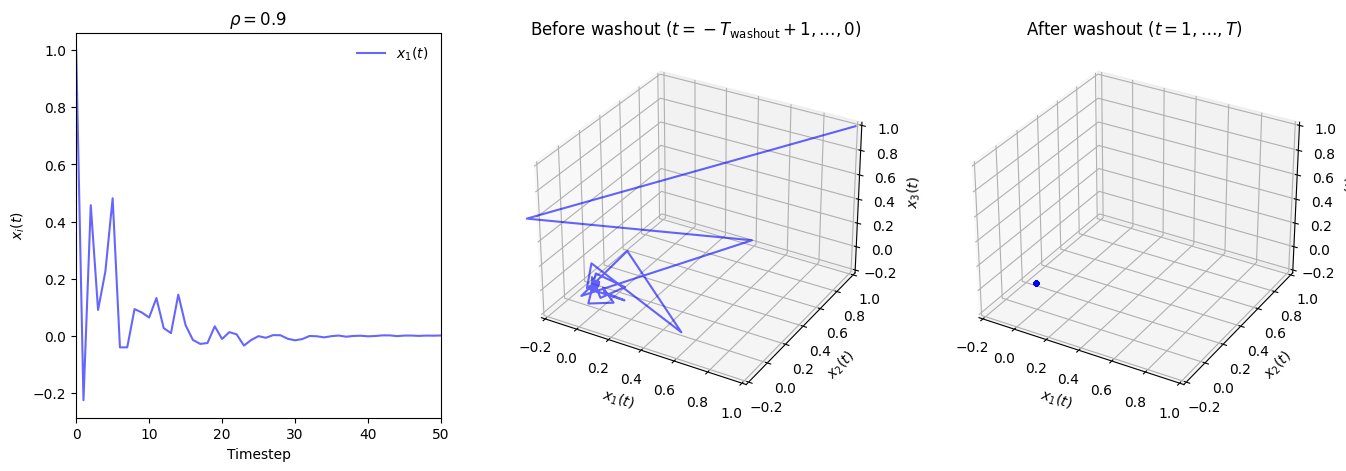

In [ ]:
# Parameters
Two,T = 1000,1000

N = 500
rho = 0.9
sigma = 0.1 # Not used in autonomous cases
p,pin = 1,1

# Input
u = np.zeros(Two+T)

esn = ESN(N,rho,sigma,p,pin)
X = esn.run(u)
print('X',X.shape)

fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(131)
ax.plot(X[:,0],label=r'$x_1(t)$',color='blue',alpha=0.6)
ax.set_xlim(0,50)
ax.set_xlabel('Timestep')
ax.set_ylabel(r'$x_{i}(t)$')
ax.legend(loc="upper right", frameon=False)
ax.set_title(r'$\rho=%.1f$'%rho)

ax = fig.add_subplot(132, projection='3d')
ax.plot(X[:Two,0], X[:Two,1], X[:Two,2], color="blue",ls='-',marker='',alpha=0.6)
ax.set_xlabel(r'$x_1(t)$')
ax.set_ylabel(r'$x_2(t)$')
ax.set_zlabel(r'$x_3(t)$')
ax.set_xlim(-0.2,1)
ax.set_ylim(-0.2,1)
ax.set_zlim(-0.2,1)
ax.set_title(r'Before washout ($t=-T_{\rm washout}+1,\ldots,0$)')

ax = fig.add_subplot(133, projection='3d')
ax.plot(X[Two:,0], X[Two:,1], X[Two:,2], color="blue",ls='-',marker='.',alpha=0.6)
ax.set_xlabel(r'$x_1(t)$')
ax.set_ylabel(r'$x_2(t)$')
ax.set_zlabel(r'$x_3(t)$')
ax.set_xlim(-0.2,1)
ax.set_ylim(-0.2,1)
ax.set_zlim(-0.2,1)
ax.set_title(r'After washout ($t=1,\ldots,T$)')


#### Strange Attractor
On the other hand, the ESN with a large $N$ exhibits chaos with $\rho>1$.
Chaos is a dynamical behaviour where the system state
1. is bounded in a certain range
1. is non-periodic
1. is sensitive to the initial value (the behaviour drastically changes depending on the initial value)

We can see a chaos of ESN with the spectral radius $\rho>1$.
The following figure shows the dynamics of ESN with $\rho=1.3$.


X (5000, 500)


Text(0.5, 0.92, 'After washout ($t=1,\\ldots,T$)')

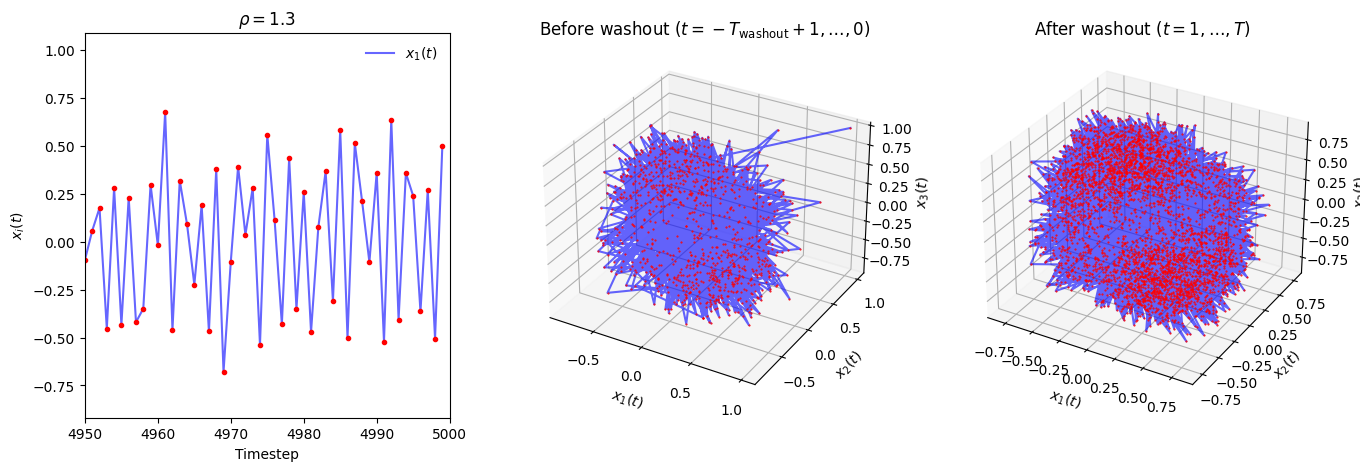

In [ ]:
# Parameters
Two,T = 1000,4000

N = 500
rho = 1.3
sigma = 0.1 # Not used in autonomous cases
p,pin = 1,1

# Input
u = np.zeros(Two+T)

esn = ESN(N,rho,sigma,p,pin)
X = esn.run(u)
print('X',X.shape)

fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(131)
ax.plot(X[:,0],label=r'$x_1(t)$',color='b',alpha=0.6)
ax.plot(X[:,0],color='red',marker='.',ls='')
ax.set_xlim(Two+T-50,Two+T)
ax.set_xlabel('Timestep')
ax.set_ylabel(r'$x_{i}(t)$')
ax.legend(loc="upper right", frameon=False)
ax.set_title(r'$\rho=%.1f$'%rho)

ax = fig.add_subplot(132, projection='3d')
ax.plot(X[:Two,0], X[:Two,1], X[:Two,2], color="blue",ls='-',marker='',alpha=0.6)
ax.plot(X[:Two,0], X[:Two,1], X[:Two,2], color="red",marker='.',ms=1,ls='')
ax.set_xlabel(r'$x_1(t)$')
ax.set_ylabel(r'$x_2(t)$')
ax.set_zlabel(r'$x_3(t)$')
ax.set_title(r'Before washout ($t=-T_{\rm washout}+1,\ldots,0$)')

ax = fig.add_subplot(133, projection='3d')
ax.plot(X[Two:,0], X[Two:,1], X[Two:,2], color="blue",ls='-',marker='',alpha=0.6)
ax.plot(X[Two:,0], X[Two:,1], X[Two:,2], color="red",marker='.',ms=1,ls='')
ax.set_xlabel(r'$x_1(t)$')
ax.set_ylabel(r'$x_2(t)$')
ax.set_zlabel(r'$x_3(t)$')
ax.set_title(r'After washout ($t=1,\ldots,T$)')

#### Periodic Attractor
If $N$ is sufficiently large, the ESN directly transits from the fixed-point to the chaos; however, the dynamics can oscillate with the small number of nodes.


X (2000, 500)


Text(0.5, 0.92, 'After washout ($t=1,\\ldots,T$)')

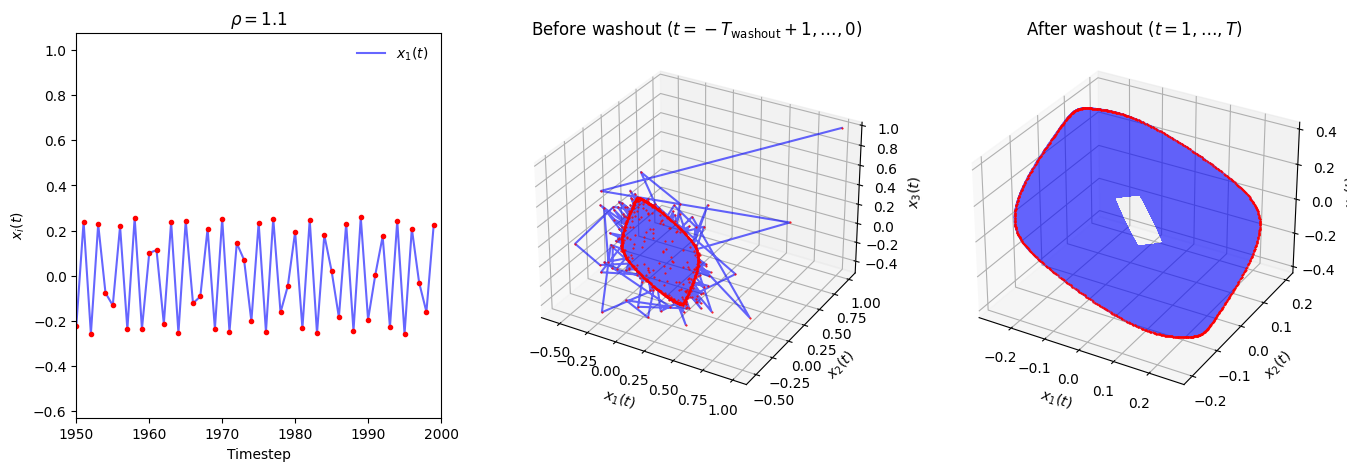

In [ ]:
# Parameters
Two,T = 1000,1000

N = 500
rho = 1.1
sigma = 0.1 # Not used in autonomous cases
p,pin = 1,1

# Input
u = np.zeros(Two+T)

esn = ESN(N,rho,sigma,p,pin)
X = esn.run(u)
print('X',X.shape)

fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(131)
ax.plot(X[:,0],label=r'$x_1(t)$',color='b',alpha=0.6)
ax.plot(X[:,0],color='red',marker='.',ls='')
ax.set_xlim(Two+T-50,Two+T)
ax.set_xlabel('Timestep')
ax.set_ylabel(r'$x_{i}(t)$')
ax.legend(loc="upper right", frameon=False)
ax.set_title(r'$\rho=%.1f$'%rho)

ax = fig.add_subplot(132, projection='3d')
ax.plot(X[:Two,0], X[:Two,1], X[:Two,2], color="blue",ls='-',marker='',alpha=0.6)
ax.plot(X[:Two,0], X[:Two,1], X[:Two,2], color="red",marker='.',ms=1,ls='')
ax.set_xlabel(r'$x_1(t)$')
ax.set_ylabel(r'$x_2(t)$')
ax.set_zlabel(r'$x_3(t)$')
ax.set_title(r'Before washout ($t=-T_{\rm washout}+1,\ldots,0$)')

ax = fig.add_subplot(133, projection='3d')
ax.plot(X[Two:,0], X[Two:,1], X[Two:,2], color="blue",ls='-',marker='',alpha=0.6)
ax.plot(X[Two:,0], X[Two:,1], X[Two:,2], color="red",marker='.',ms=1,ls='')
ax.set_xlabel(r'$x_1(t)$')
ax.set_ylabel(r'$x_2(t)$')
ax.set_zlabel(r'$x_3(t)$')
ax.set_title(r'After washout ($t=1,\ldots,T$)')

#### Phase Transition
As we increase the spectral radius, we can see some behaviours such as a fixed-point, oscillation, and chaos.

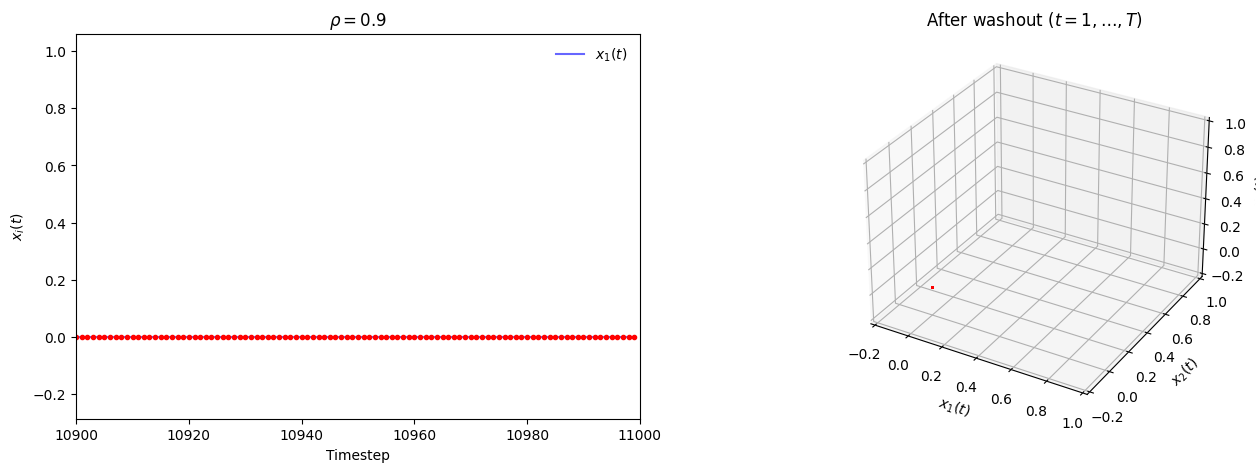

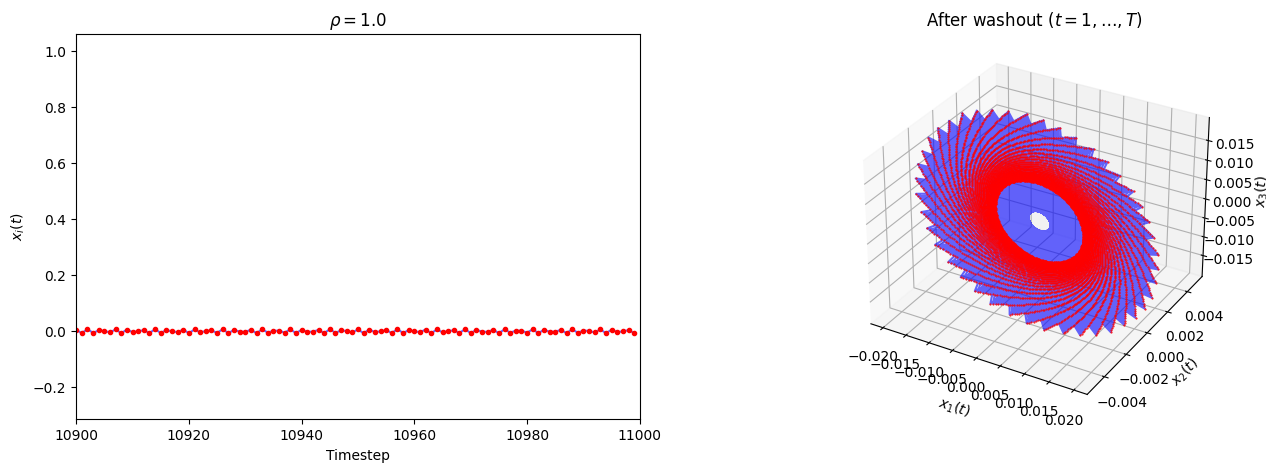

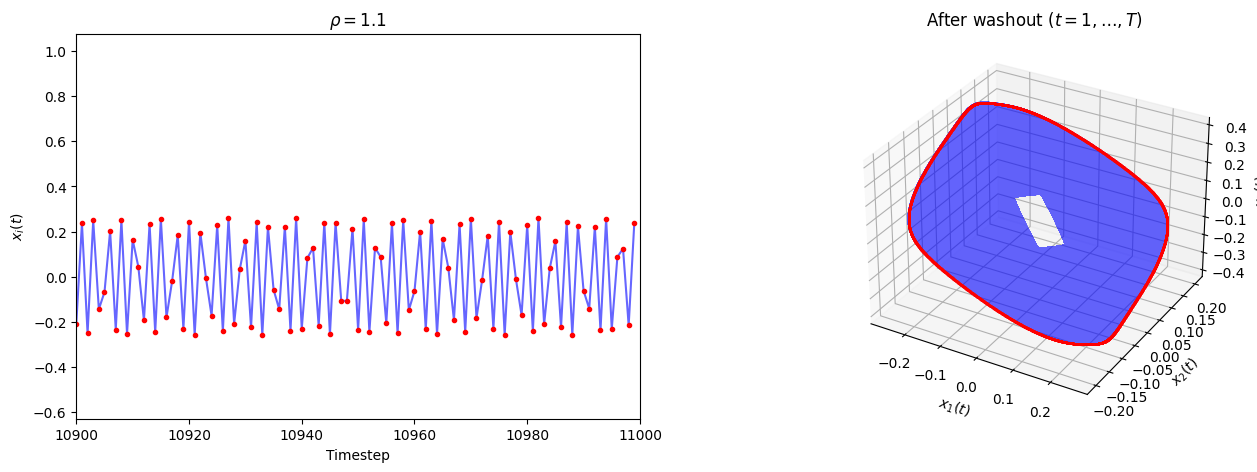

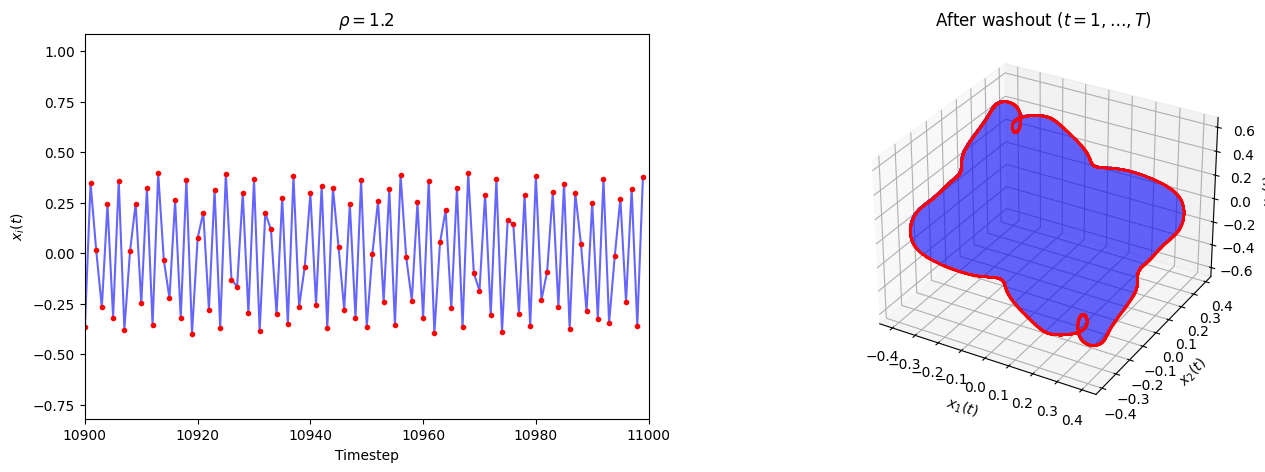

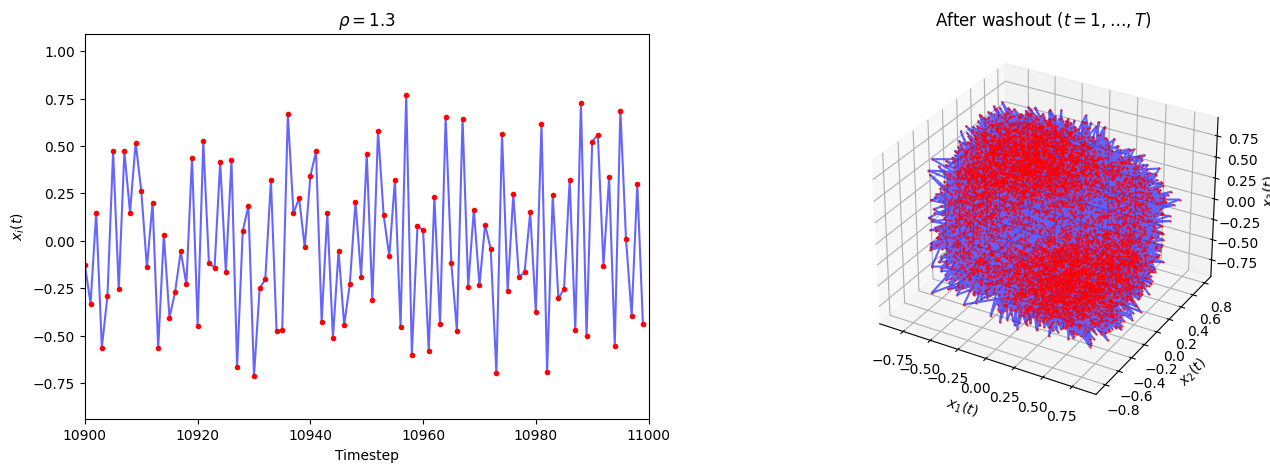

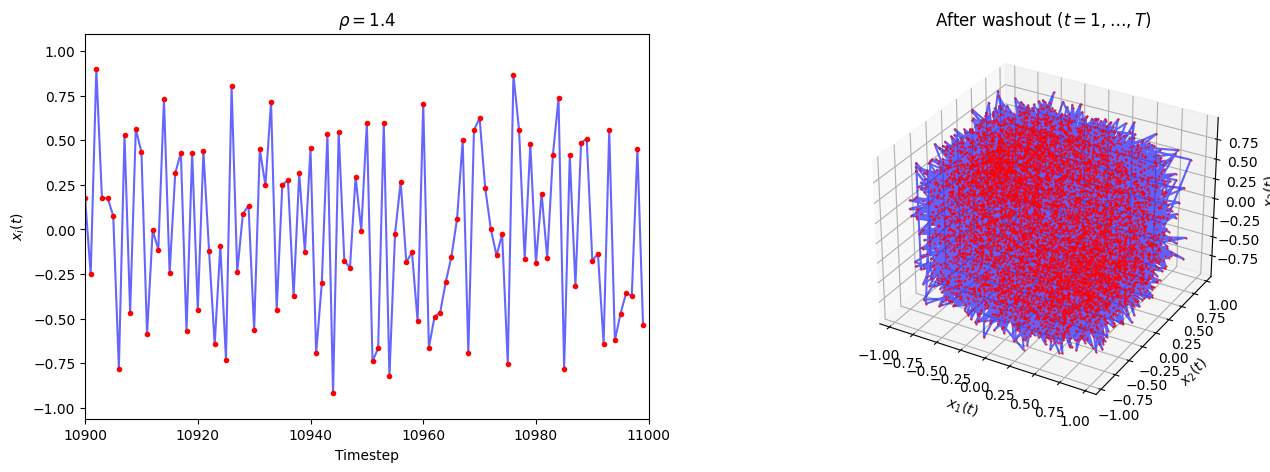

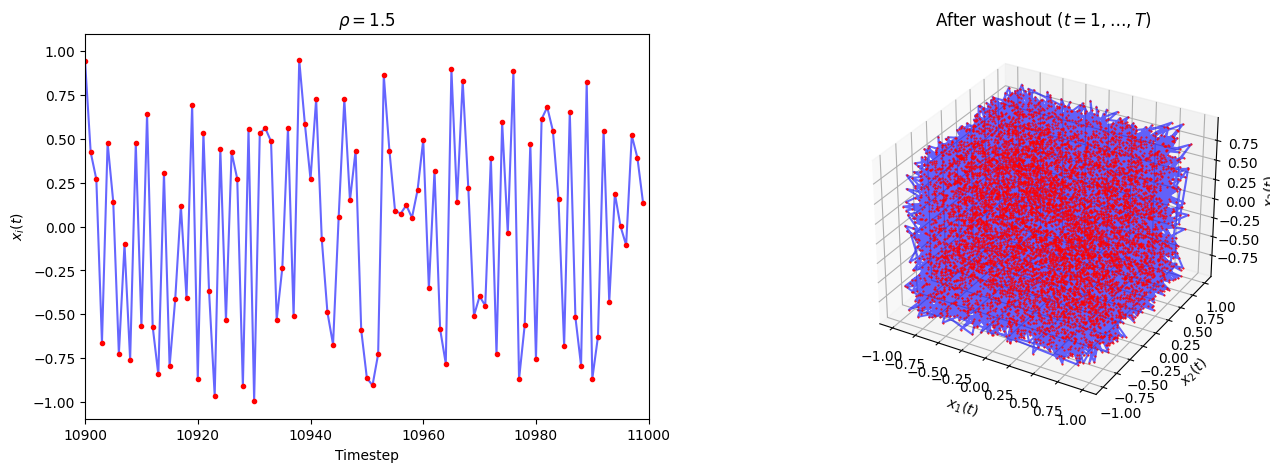

In [ ]:
# Parameters
Two,T = 1000,10000

N = 500
sigma = 0.1 # Not used in autonomous cases
p,pin = 1,1

# Input
u = np.zeros(Two+T)

for i,rho in enumerate([0.9,1,1.1,1.2,1.3,1.4,1.5]):
    esn = ESN(N,rho,sigma,p,pin)
    X = esn.run(u)

    fig = plt.figure(figsize=(16,5))

    ax = fig.add_subplot(121)
    ax.plot(X[:,0],label=r'$x_1(t)$',color='blue',alpha=0.6)
    ax.plot(X[:,0],color='red',marker='.',ls='')
    ax.set_xlim(Two+T-100,Two+T)
    ax.set_xlabel('Timestep')
    ax.set_ylabel(r'$x_{i}(t)$')
    if i==0:
        ax.legend(loc="upper right", frameon=False)
    ax.set_title(r'$\rho=%.1f$'%rho)

    ax = fig.add_subplot(122, projection='3d')
    ax.plot(X[Two:,0], X[Two:,1], X[Two:,2], color="blue",ls='-',marker='',alpha=0.6)
    ax.plot(X[Two:,0], X[Two:,1], X[Two:,2], color="red",marker='.',ms=1,ls='')
    ax.set_xlabel(r'$x_1(t)$')
    ax.set_ylabel(r'$x_2(t)$')
    ax.set_zlabel(r'$x_3(t)$')
    if i==0:
        ax.set_xlim(-0.2,1)
        ax.set_ylim(-0.2,1)
        ax.set_zlim(-0.2,1)
    ax.set_title(r'After washout ($t=1,\ldots,T$)')
    plt.show()


#### Bifurcation Diagram
With a large $N$, the ESN without input directly transits from a fixed-point to chaos at $\rho=1$.
Such dynamical phase transition is called bifurcation, which can be illustrated by bifurcation diagram.
In the bifurcation diagram, the horizontal axis is a parameter and the vertical one is a system state.
The behaviour suddenly transits at a value of parameter, which is called a bifurcation point.

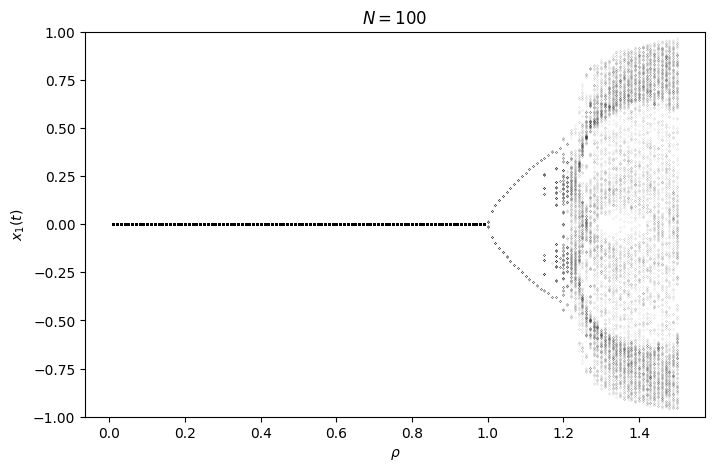

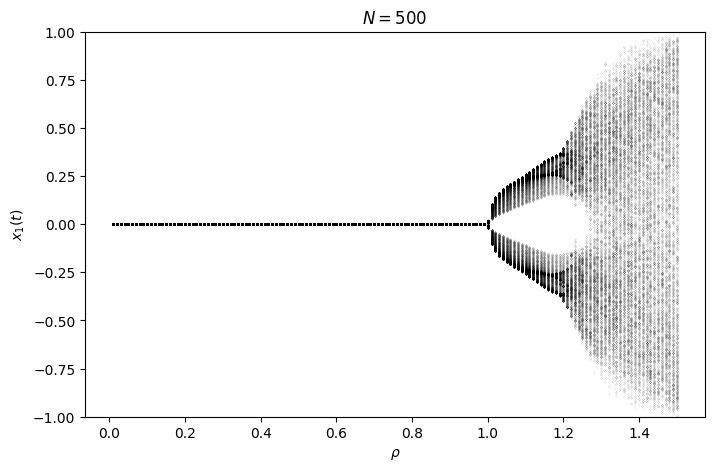

In [ ]:
# Parameters
Two,T = 1000,1000
rhos = np.arange(0.01,1.51,0.01)
sigma = 0.1 # Not used
p,pin = 1,1

# Input
u = np.zeros(Two+T)

for N in [100,500]:
    fig = plt.figure(figsize=(8,5))
    for i,rho in enumerate(rhos):
        esn = ESN(N,rho,sigma,p,pin)
        X = esn.run(u)
        if rho<1:
            plt.plot(rho*np.ones(T),X[Two:,0],color='black',marker='.',markersize=0.1,linestyle='')
        else:
            X0 = X[Two:,0]
            index_positive = sp.signal.find_peaks(X0)[0]
            index_negative = sp.signal.find_peaks(-X0)[0]
            index = np.concatenate([index_positive,index_negative])
            X0 = X0[index]
            # print(rho,X0)
            plt.plot(rho*np.ones(len(X0)),X0,color='black',marker='.',markersize=0.1,linestyle='')
    plt.xlabel(r'$\rho$')
    plt.ylabel(r'$x_{1}(t)$')
    plt.ylim(-1,1)
    plt.title(r'$N=%d$'%N)


##### Local optima provides a clear bifurcation diagram of consinuous state
Note that, in a case that the range of state is continuous, it is difficult to find bifurcation from the state.
Local minima and maxima of the state provide a more clear bifurcation diagram than all of the state.
For example, if the periodic state is represented by $x_t=\sin(\omega t)$, the state distributes from $-1$ to $1$, which is difficult to distinguish from chaos.
Local minima and maxima of periodic state are $-1$ and $1$, while those of chaotic state continuously distribute.

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]


[Text(0, -1.5, ''),
 Text(0, -1.0, ''),
 Text(0, -0.5, ''),
 Text(0, 0.0, ''),
 Text(0, 0.5, ''),
 Text(0, 1.0, ''),
 Text(0, 1.5, '')]

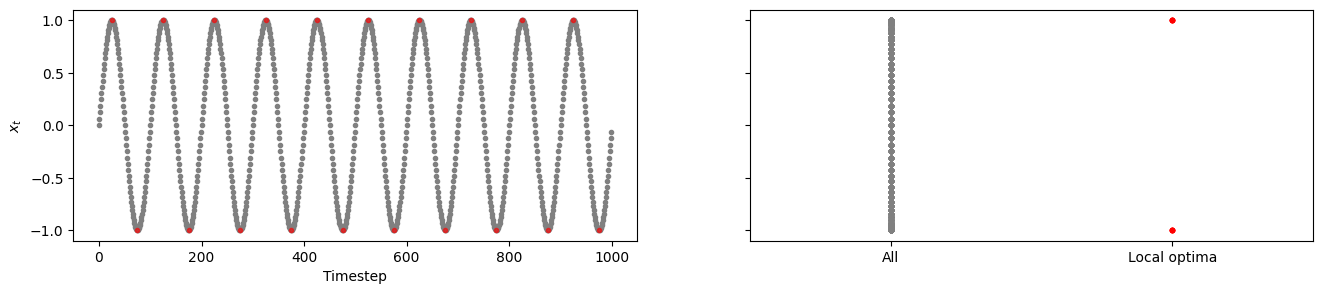

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

f = 10
T = 1000
t = np.arange(T)
x = np.sin(2*np.pi*f/T*t)

index_minima = sp.signal.find_peaks(-x)[0]
index_maxima = sp.signal.find_peaks(x)[0]
index = np.concatenate([index_minima,index_maxima])
xopt = x[index]

fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(121)
ax.plot(x,c='gray',marker='.',ls='')
ax.plot(index,xopt,marker='.',ls='',c='r',alpha=0.6)
ax.set_xlabel('Timestep')
ax.set_ylabel(r'$x_t$')

ax = fig.add_subplot(122)
ax.plot(np.ones(T),x,c='gray',marker='.',ls='')
ax.set_yticklabels([])
print(xopt)

ax.plot(2*np.ones(len(xopt)),xopt,c='r',alpha=0.6,marker='.',ls='')
ax.set_xlim(0.5,2.5)
ax.set_xticks([1,2])
ax.set_xticklabels(['All','Local optima'])
ax.set_yticklabels([])


##### Edge of Chaos
Ideally, the ESN transits from order to chaos at $\rho=1$, which is called the <b>edge of chaos (カオスの縁)</b>.
In the above bifurcation diagrams, the state oscillates with $\rho > 1.00$. Therefore, in the cases that the ESN demonstrates oscillation, the edge moves to $\rho>1$.
We can find two bifurcation points of the ESN with $N=100,500$
- At $\rho=0$, the ESN transits from the fixed-point to periodic state
- At $\rho=1.2$–$1.3$, the ESN may transit from the periodic to chaotic state

#### Lyapunov Exponent
How can we represent the initial sensitivity using equations?
We can describe it using a state equation for a difference of two states.  

##### One-dimensional case

We assume that a one-dimensional discrete-time system
\begin{align}
x_{t+1} = f(x_t) \tag{1}
\end{align}
has the initial sensitivity and the two systems have slightly different initial values.
Let the two system states be  $x_t^{(1)}, x_t^{(2)}$ and the difference of initial values be $\delta x_0=x_0^{(1)}-x_0^{(2)}$.
We can linearize Eq. (1) around $x_t=a_t$ as
$$
x_{t+1} \approx a_t + \frac{d f}{d x}\Big|_{x_t=a_t}(x_t-a_t) \tag{2}
$$
Using Eq. (2), we describe state equation of $\delta x_t = x_t^{(1)}-x_t^{(2)}$ as
\begin{align}
\delta x_{t+1} &\approx \frac{d f}{d x}\Big|_{x_t=a_t} \delta x_t = D_t \delta x_t.
\end{align}
After a sufficiently long time $T$,
\begin{align}
\delta x_{T} &\approx (D_{T-1}D_{T-2}\cdots D_0) \delta x_0, \tag{3}
\end{align}
According to Eq. (3), if the time average of absolute values of slope
\begin{align}
\bar{D} = |D_{T-1}D_{T-2}\cdots D_0|^{1/T} \tag{4}
\end{align}
is greater (less) than $1$, $|\delta x_T|$ diverges to infinity (converges to $0$).
The Lyapunov exponent $\lambda$ is an exponential expansion rate of state, which is described by
\begin{align}
\left|\frac{\delta x_T}{\delta x_0}\right| = (e^\lambda)^T.
\end{align}
Therefore, we obtain
\begin{align}
\lambda &= \ln\bar{D} = \frac{1}{T}\sum_{t=0}^{T-1} \ln|D_t|.
\end{align}
If $\lambda>0$, the two trajectories are separated, which indicates the initial sensitivity.




##### $N$-dimensional case

We consider a $N$-dimensional discrete-time system. The state $\boldsymbol{x}_t=[x_{1,t} \cdots x_{N,t}]^\top$ is update via the state equation
\begin{align}
\boldsymbol{x}_{t+1} = \boldsymbol{f}(\boldsymbol{x}_t),
\end{align}
where $\boldsymbol{f}= [f_1 \cdots f_N]^\top$ is a $N$-dimensional map.
In the same manner as the one-dimensional case, the $N$-dimensional state can be linearized and the state equation of the difference is descibed by
\begin{align}
\delta \boldsymbol{x}_{t+1} &\approx \boldsymbol{J}_t \delta \boldsymbol{x}_t,
\end{align}
where $\boldsymbol{J}_t$ represents the Jacobian matrix of $f$ and is given by
$$
\boldsymbol{J}_t =
\begin{bmatrix}
\dfrac{\partial f_1}{\partial x_{1,t}} & \cdots & \dfrac{\partial f_1}{\partial x_{N,t}} \\
\vdots & \ddots & \vdots \\ \dfrac{\partial f_N}{\partial x_{1,t}} & \cdots & \dfrac{\partial f_N}{\partial x_{N,t}}
\end{bmatrix}.
$$
After a sufficiently long time $T$, the final state $\delta x_T$ is represented by
\begin{align}
\delta \boldsymbol{x}_{T} &\approx (\boldsymbol{J}_{T-1}\boldsymbol{J}_{T-2}\cdots \boldsymbol{J}_0) \delta \boldsymbol{x}_0, \tag{5}
\end{align}
In the $N$-dimensional case, we have $N$ expansion rates, which are represented by eigenvalues of matrix
$$
\boldsymbol{M}_T = \boldsymbol{J}_{T-1}\boldsymbol{J}_{T-2}\cdots\boldsymbol{J}_0
$$
because multiplying matrix is decomposed into the rotation and scaling and the scaling is represented by the absolute values of eigenvalues.
The matrix $\boldsymbol{M}_T$ can be diagonalized by
$$
\boldsymbol{M}_T = \boldsymbol{P}\boldsymbol{A}\boldsymbol{P}^{-1},
$$
where $\boldsymbol{A}$ is a diagonal matrix whose elements are eigenvalues $\{\alpha_1,\ldots,\alpha_N\}$ of $\boldsymbol{M}_T$ and $\boldsymbol{P}$ is a matrix whose column vectors are eigenvectors of $\boldsymbol{M}_T$.
Therefore, Eq. (5) is rewritten as
\begin{align}
\delta \boldsymbol{x}_{T} &= \boldsymbol{P}\boldsymbol{A}\boldsymbol{P}^{-1} \delta \boldsymbol{x}_0 \\
\boldsymbol{P}^{-1}\delta \boldsymbol{x}_{T} &= \boldsymbol{A} (\boldsymbol{P}^{-1} \delta \boldsymbol{x}_0).
\end{align}
Defining a new variable of $\delta \boldsymbol{y}_t=\boldsymbol{P}^{-1} \delta\boldsymbol{x}_t=[\delta y_{1,t}\cdots \delta y_{N,t}]^\top$, we obtain
\begin{align}
\delta \boldsymbol{y}_T &= \begin{bmatrix}
\alpha_1 & & \\
& \ddots & \\
& & \alpha_N
\end{bmatrix}
\delta \boldsymbol{y}_0 \\
\delta y_{i,T} &= \alpha_i \delta y_{i,0} ~ (i=1,\ldots,N),
\end{align}
which is the same expression as Eq. (3).
This diagonal factorization provides
\begin{align}
\lambda_i &= \frac{1}{T} \ln|\alpha_i|~(i=1,\ldots,N).
\end{align}
Accordingly, in the $N$-dimensional case, we obtain $N$ exponents. The set of them $\{\lambda_1,\ldots,\lambda_N\}$ is called the <b>Lyapunov spectrum</b>.
If the <b>maximum Lyapunov exponent</b> $\max_i \lambda_i>0$, the two trajectories are separated, which indicates the initial sensitivity.

Note that, if $\boldsymbol{x}_{t+1} = \tanh(W \boldsymbol{x}_t)$, the Jacobian can be simplified to
\begin{align}
\boldsymbol{J}_t = {\rm diag}(\boldsymbol{1}-\tanh^2(Wx_t))\cdot\boldsymbol{W}
= {\rm diag}(\boldsymbol{1}-x_{t+1}^2)\cdot\boldsymbol{W},
\end{align}
where $\boldsymbol{1}=[1\cdots 1]^\top$ is a vector that has $N$ elements of $1$ and ${\rm diag}(\boldsymbol{y})$ is the diagonal matrix whose diagonal elements are $\boldsymbol{y}=[y_1\cdots y_N]^\top$, i.e.,
\begin{align}
{\rm diag}(\boldsymbol{y}) =
\begin{bmatrix}
y_1 & & \\
& \ddots & \\
& & y_N
\end{bmatrix}.
\end{align}


Text(0, 0.5, '$\\lambda_1$')

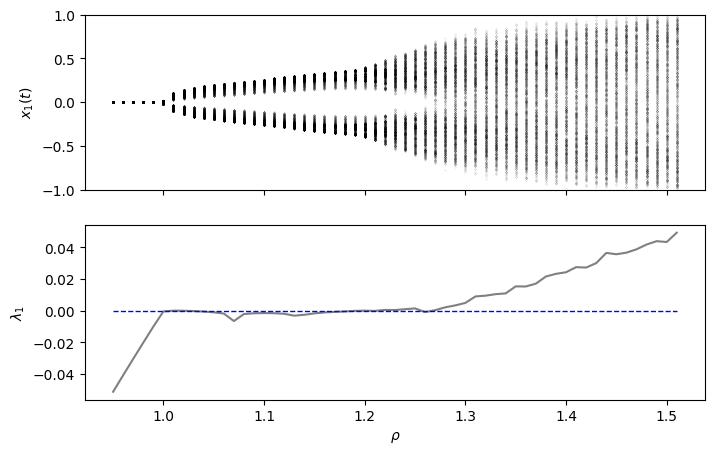

In [ ]:
import numpy as np
import scipy

# Parameters
Two,T = 1000,1000

N = 500
sigma = 0.1 # Not used in autonomous cases
p,pin = 1,1

# Input
u = np.zeros(Two+T)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(211)

rhos = np.arange(0.95,1.51,0.01)
ls = []
for rho in rhos:
    esn = ESN(N,rho,sigma,p,pin)
    X = esn.run(u)
    M = np.eye(N)
    for t in range(Two,Two+T):
        J = np.diag( 1-X[t]**2 ) @ esn.W
        M = J @ M

    l = np.log(np.abs(np.linalg.eigvals(M)))/T
    ls.append(l.max())

    # Bifurcation diagram
    if rho<1:
        plt.plot(rho*np.ones(T),X[Two:,0],color='black',marker='.',markersize=0.1,linestyle='')
    else:
        X0 = X[Two:,0]
        index_positive = sp.signal.find_peaks(X0)[0]
        index_negative = sp.signal.find_peaks(-X0)[0]
        index = np.concatenate([index_positive,index_negative])
        X0 = X0[index]
        ax.plot(rho*np.ones(len(X0)),X0,color='black',marker='.',markersize=0.1,linestyle='')

ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel(r'$x_{1}(t)$')
ax.set_ylim(-1,1)



ax = fig.add_subplot(212)
ax.plot(rhos,ls,c='gray')
ax.plot([rhos.min(),rhos.max()],[0,0],ls='--',lw=1,c='blue')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\lambda_1$')


##### Methods other than using Jacobian matrix
- With equations
 - Shimada-Nagashima method
- Without equations
  - Rosenstein-Kantz method

#### Homework #1: Bifurcation diagram and Lyapunov exponent of logistic map
The state equation of the logistic map is given by
$$
x_{t+1} = ax_t(1-x_t),
$$
where $x_t\in[0,1]$ is a state and $a$ is $a\in(0,4]$ constant parameter.

Practices:
1. Plot time-series with $a=2$ (fixed-point), $a=3$ (period two) and $a=4$ (chaos).
1. Draw a bifurcation diagram of this map.
1. Calculate a derivative $D_t$ of this map.
1. Calculate the Lyapunov exponent $\lambda$ of this map and illustrate the relationship between the parameter $a$ and $\lambda$.

Hint: The state $x_t$
- converges to a fixed point with $a<3$
- oscillates with $3\le a\le 3.569\cdots$
- demostrates chaos with $a>3.569\cdots$ (but sometimes oscillates with period three or something)


<ipython-input-58-d74c8d424e0c>:18: RuntimeWarning: divide by zero encountered in log
  l = np.mean(np.log(np.abs(D[Two:])))


Text(0, 0.5, '$\\lambda$')

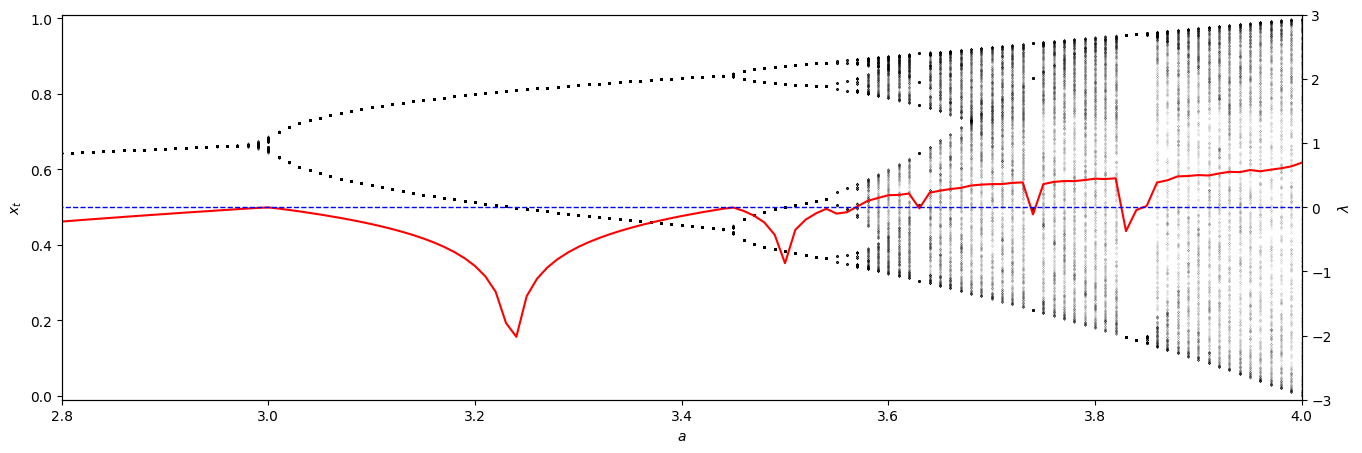

### Input-Induced Phenomena
If a dynamical system receives an input, its dynamical behaviour can change.
Here we introduce some important phenomena for reservior computing.



#### Noise-Induced Order
Chaos can be supperssed by noise input.
The initial sensitivity, which is a feature of chaos, can be lost by added input and thus the system does not show chaotic behaviour.
This phenomenon is called noise-induced order.
In the following example, the chaotic ESN loses the sensitivity to initial values by receiving a noise input.

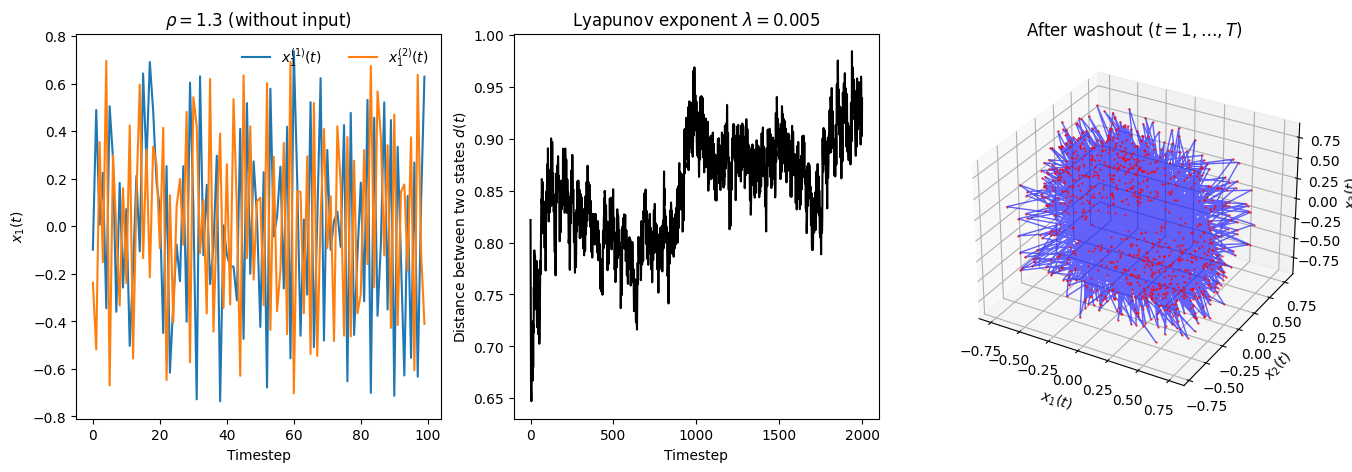

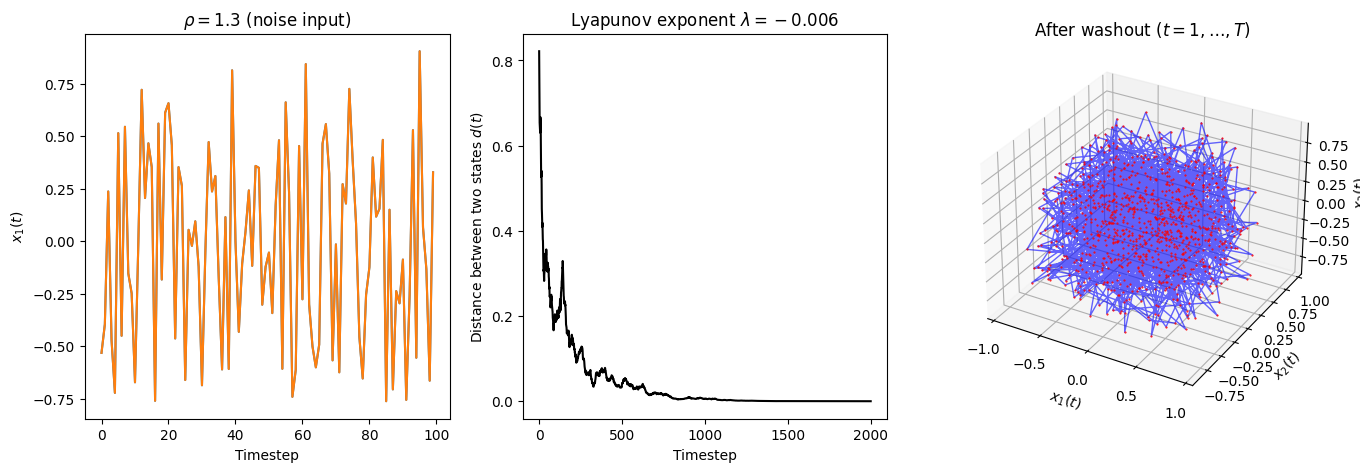

In [ ]:
# Parameters
Two,T = 1000,4000
Two,T = 1000,1000

N = 500
rho = 1.3
sigma = 0.5
p,pin = 1,1
esn = ESN(N,rho,sigma,p,pin)

# Initial values
X0_1,X0_2 = np.ones(N),np.ones(N)
X0_2[0] = 0.99
np.random.seed(1)
X0_1,X0_2 = 2*np.random.rand(N)-1,2*np.random.rand(N)-1

# Input
np.random.seed(0)
u_noise = 2*np.random.rand(Two+T)-1
u_zero = np.zeros(Two+T)
u = {'noise':u_noise,'without':u_zero}

for i,label in enumerate(['without','noise']):
    X1 = esn.run(u[label],X0=X0_1)
    X2 = esn.run(u[label],X0=X0_2)
    # Distance
    d = np.sqrt(np.mean((X1-X2)**2,axis=1))
    # Lyapunov spectrum
    M = np.eye(N)
    for t in range(Two,Two+T):
        M = (np.diag( 1-X1[t]**2 ) @ esn.W) @ M
    l = np.log(np.abs(np.linalg.eigvals(M)))/T

    fig = plt.figure(figsize=(16,5))

    ax = fig.add_subplot(131)
    ax.plot(X1[-100:,0],label=r'$x_1^{(1)}(t)$')
    ax.plot(X2[-100:,0],label=r'$x_1^{(2)}(t)$')
    ax.set_xlabel('Timestep')
    ax.set_ylabel(r'$x_{1}(t)$')
    ax.set_title(r'$\rho=%.1f$ (%s input)'%(rho,label))
    if i==0:
        ax.legend(loc='upper right',frameon=False,ncols=2)

    ax = fig.add_subplot(132)
    ax.plot(d,'k')
    ax.set_xlabel('Timestep')
    ax.set_ylabel(r'Distance between two states $d(t)$')
    ax.set_title(r'Lyapunov exponent $\lambda=%.3f$'%(l.max()))

    ax = fig.add_subplot(133, projection='3d')
    ax.plot(X1[Two:,0], X1[Two:,1], X1[Two:,2], color="blue",linewidth=1,alpha=0.6)
    ax.plot(X1[Two:,0], X1[Two:,1], X1[Two:,2], color="red",marker='.',ls='',ms=1)
    ax.set_xlabel(r'$x_1(t)$')
    ax.set_ylabel(r'$x_2(t)$')
    ax.set_zlabel(r'$x_3(t)$')
    ax.set_title(r'After washout ($t=1,\ldots,T$)')


#### Common signal-induced synchronization<sup>[6]</sup>
We can understand this phenomenon from another perspective of synchronization.
The common signal-induced synchronization<sup>[6]</sup> is a phenomenon in which the input signal is injected into two other different systems.
The response of these systems can then get synchronized, meaning that their output signals are in synchrony despite their complexity.
The procedure to confirm the ESP is presented as follows:

- Consider two systems $\boldsymbol{x}_t^{(1)}$ and $\boldsymbol{x}_t^{(2)}$ starting from different initial states $\boldsymbol{x}_0^{(1)}$ and $\boldsymbol{x}_0^{(2)}$
- Common input sequence $\{𝑢_0, 𝑢_1,\ldots\}$ is injected into systems $\boldsymbol{x}_t^{(1)}$ and $\boldsymbol{x}_t^{(2)}$
- If the distance $𝑑(\boldsymbol{x}_T^{(1)},\boldsymbol{x}_T^{(2)} )\approx 0$ when $T$ is sufficiently large, the two systems synchronize because of the common input.

<center>
    <img src="https://drive.google.com/uc?export=view&id=17j6t60BrgLNeUiiutIBlFip_MKgwIn8d" style="width:750px;height:180px;">
<figcaption align = "center"><b> Fig. 1. The common signal-induced synchronization in ESN </b></figcaption>
</center>


#### Other signal-induced phenomena
- Noise-induced chaos

 The ordered system can become chaotic by noise input.
- Signal-induced order

 Input signals other than noise can make chaotic systems ordered (e.g., chaotic ESNs become orderd by periodic inputs).

### Echo State Property

The <b>echo state property (ESP)</b> is a prerequisite for reservoir computing.
If we apply an identical input series to a dynamical system repeatedly, the dynamics should provide the same state;
otherwise, the state interrupts a reproducible output on each trial because the output is calculated by the weighted sum of states
$$
\hat{y}_t = \sum_{i=1}^N w_i x_{i,t}.
$$
Therefore, the state should be reproducible against input series.
More specifically, the state $\boldsymbol{x}_t$ should be a <b>function of past input series</b>
$$
\boldsymbol{x}_t = \boldsymbol{g}(u_{t-1},u_{t-2},\ldots),
$$
which is called an <b>echo function</b>.
The ESP is the property that the state is an echo function.


### ESP index <sup>[7]</sup>

We can verify the ESP by confirming the common signal-induced synchronization<sup>[6]</sup>.
If the two responses converge with a common input, we can calculate the output reproducibly using the linear regression.

We define the distance between the two states at $t$ timestep as
\begin{align}
d_t &= ||\boldsymbol{x}_t^{(1)}-\boldsymbol{x}_t^{(2)}||_2,
\end{align}
where $||\cdot||_2$ is the L2 norm.
As shown in subsection of noise-induced order, this distance can fluctuate due to the oscillation of states, we use the average of distance
\begin{align}
\bar{d} &= \frac{1}{S}\sum_{t=T-S+1}^T d_t,
\end{align}
where the last $S$ timesteps are used to calculate the averaged distance.

First 10 initial values of trial #1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
First 10 initial values of trial #2 [0.99 1.   1.   1.   1.   1.   1.   1.   1.   1.  ]


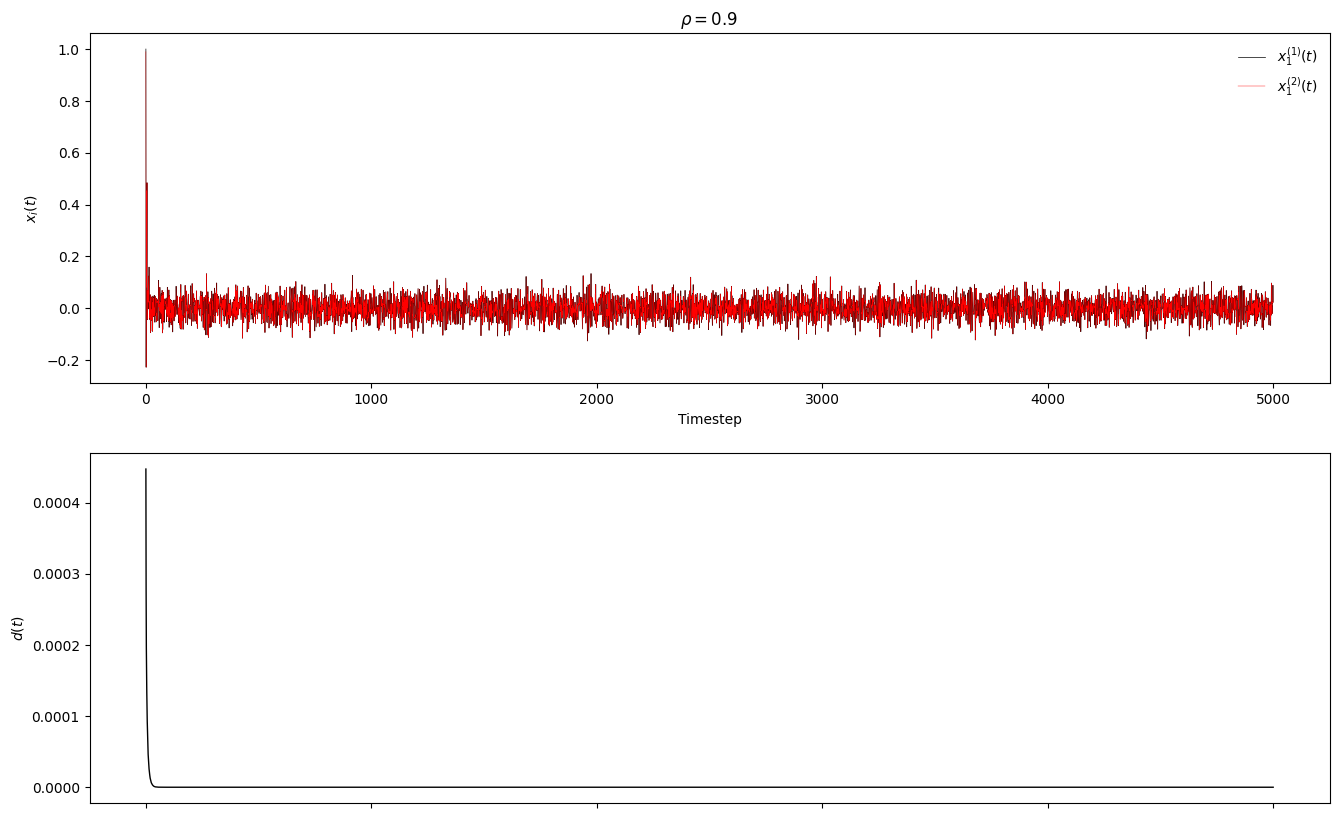

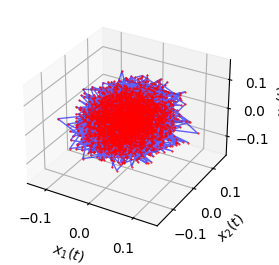

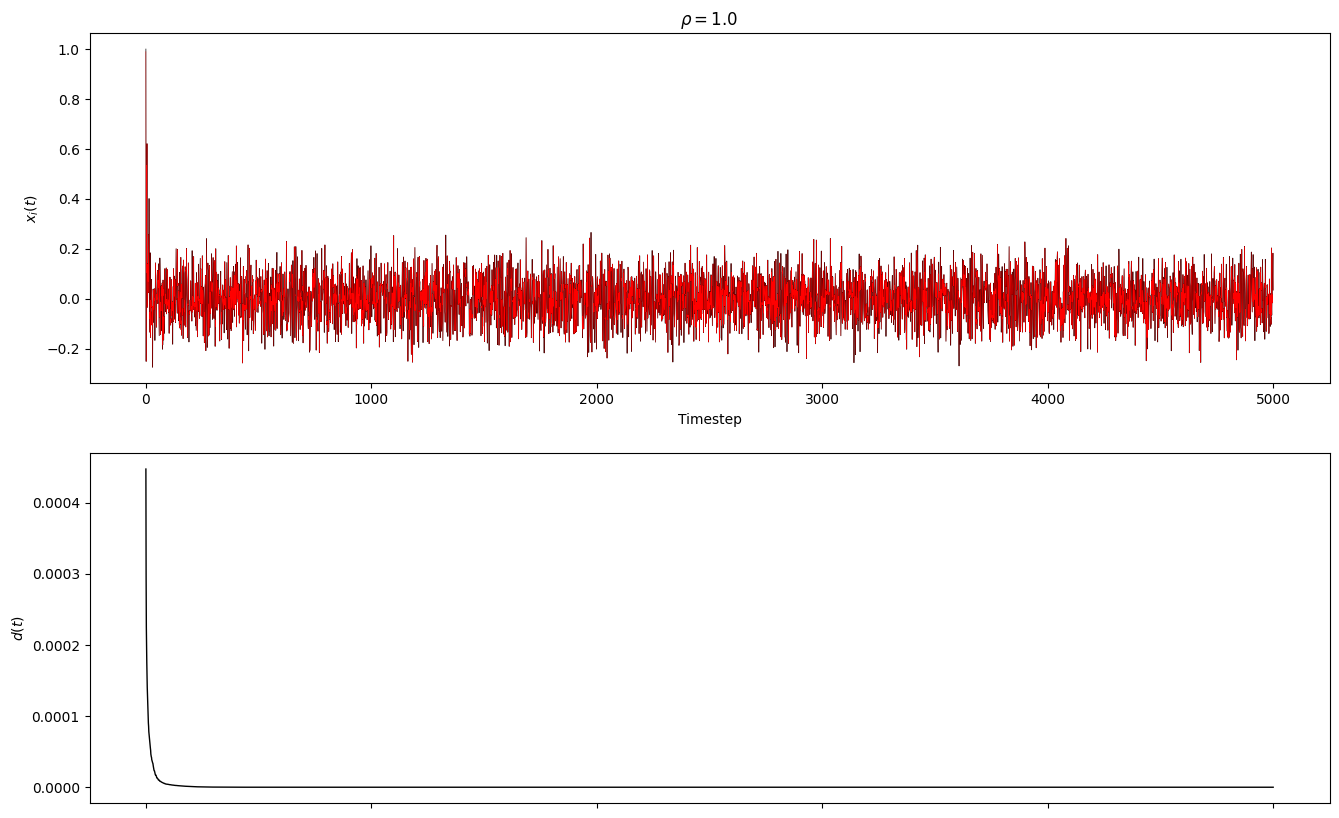

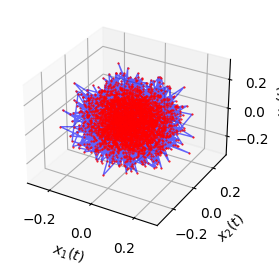

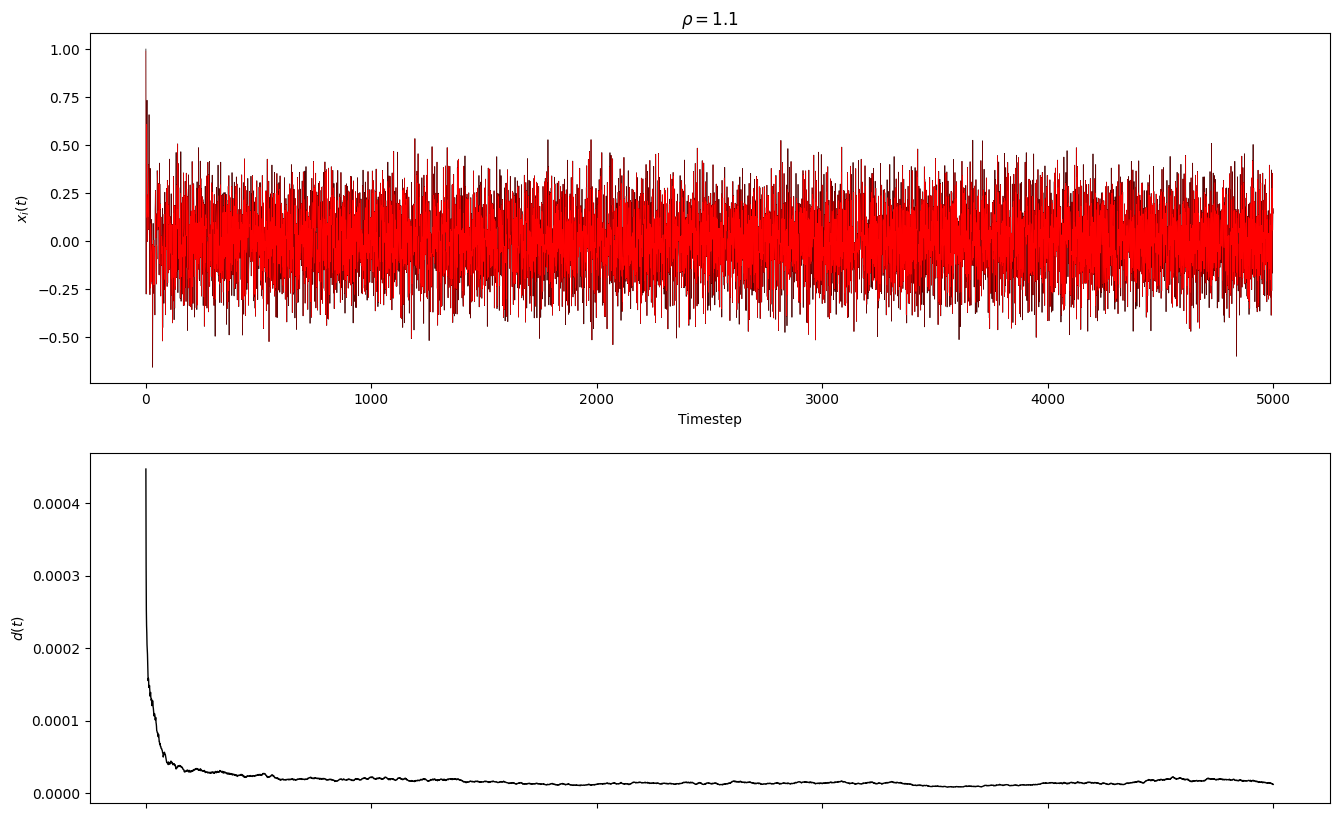

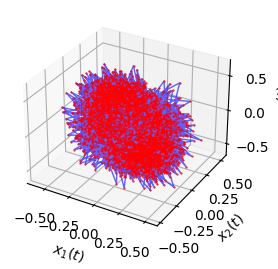

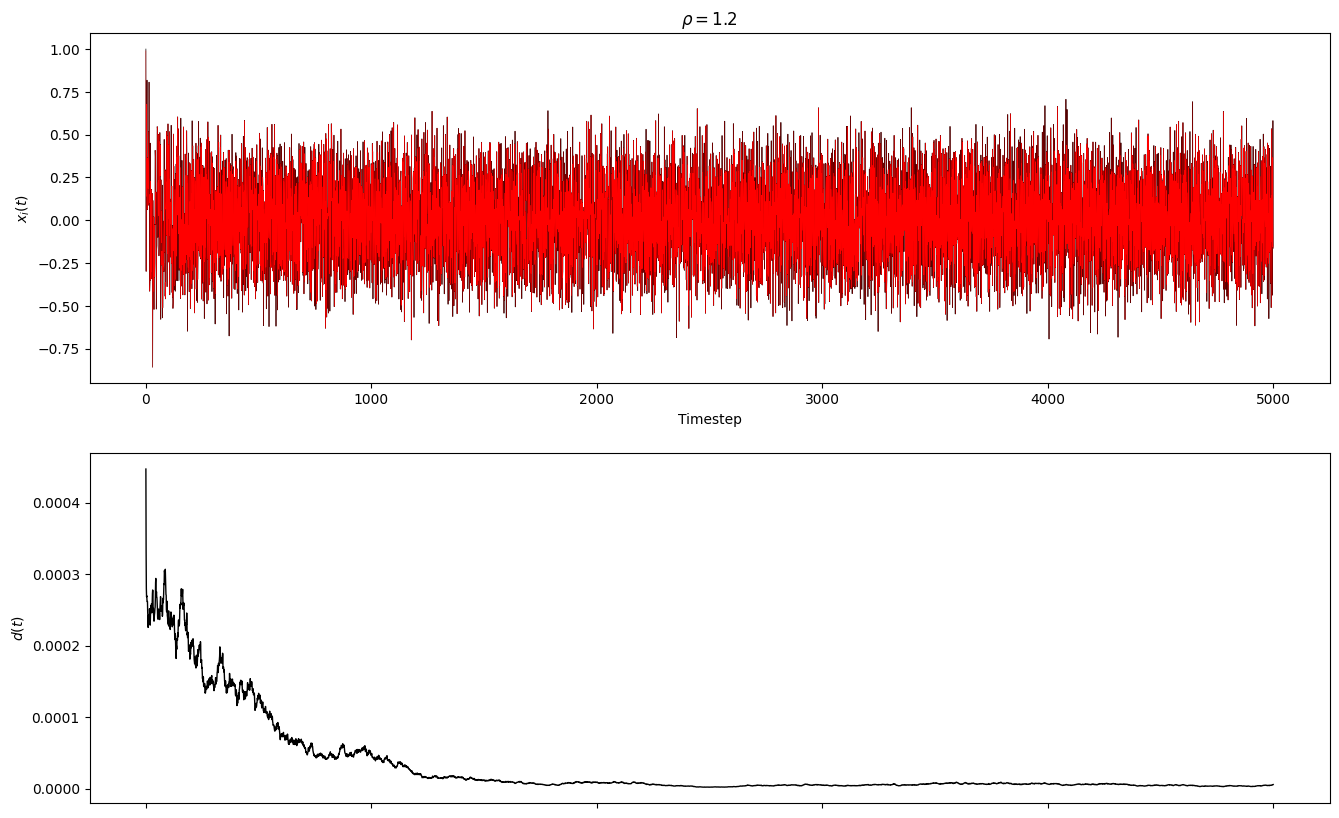

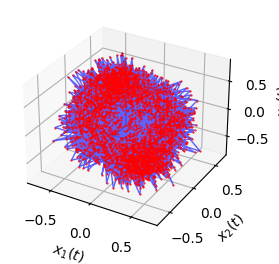

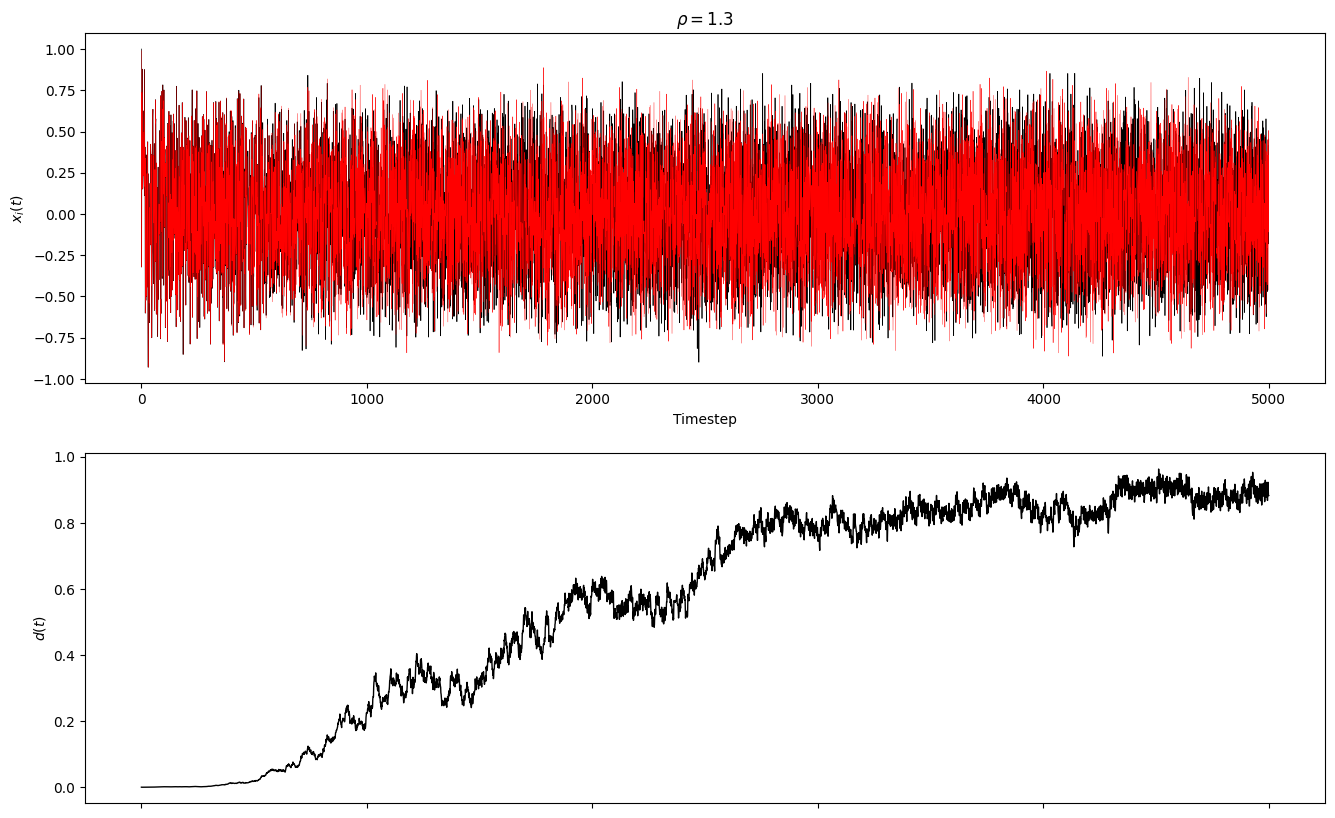

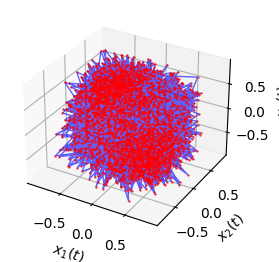

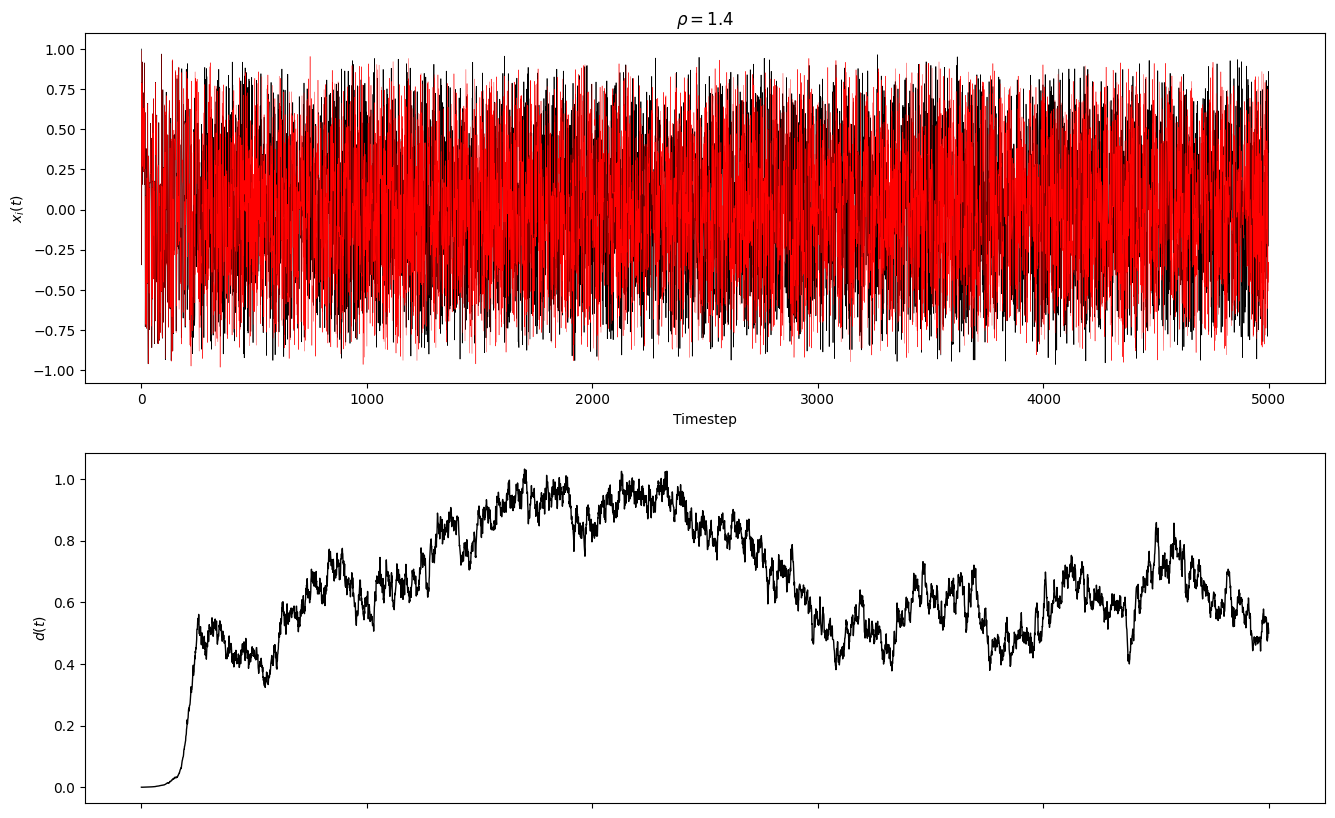

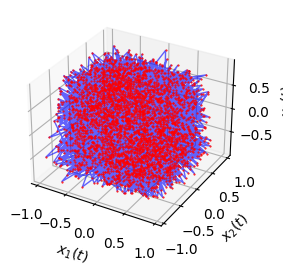

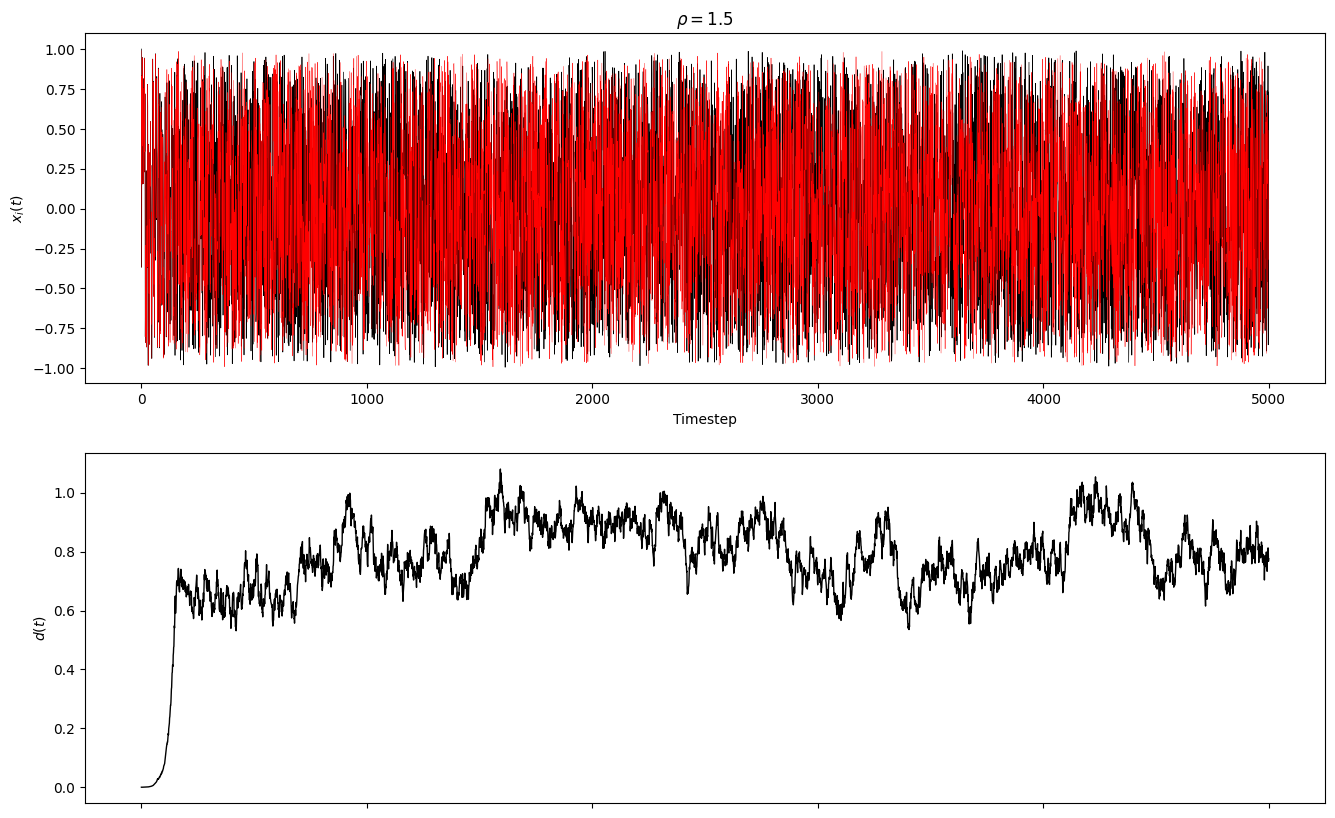

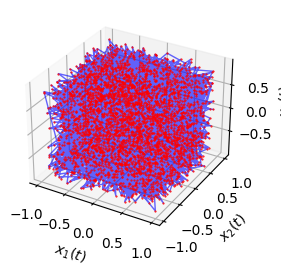

In [ ]:
# Parameters
Two,T = 1000,4000
N = 500
rhos = np.arange(0.9,1.51,0.1)
sigma = 0.1
p,pin = 1,1

# Input
np.random.seed(0)
u = 2*np.random.rand(Two+T)-1

# Initial values
X0_1 = np.ones(N)
X0_2 = np.ones(N)
X0_2[0] = 0.99
print('First 10 initial values of trial #1', X0_1[:10])
print('First 10 initial values of trial #2', X0_2[:10])

# The last 1000 steps is used to calculate mean distance
S = 1000

dbars = []
for j,rho in enumerate(rhos):
    esn = ESN(N,rho,sigma,p,pin)
    X_1 = esn.run(u,X0=X0_1)
    X_2 = esn.run(u,X0=X0_2)

    d = np.sqrt(np.mean((X_1-X_2)**2,axis=1))
    dbar = d[-S:].mean()
    dbars.append(dbar)

    fig = plt.figure(figsize=(16,10))

    ax = fig.add_subplot(211)
    ax.plot(X_1[:,0],label=r'$x_1^{(1)}(t)$',c='k',lw=0.5)
    ax.plot(X_2[:,0],label=r'$x_1^{(2)}(t)$',c='r',lw=0.3)
    ax.set_xlabel('Timestep')
    ax.set_ylabel(r'$x_{i}(t)$')
    if j==0:
        ax.legend(loc="upper right", frameon=False)
    ax.set_title(r'$\rho=%.1f$'%rho)

    ax = fig.add_subplot(212)
    ax.plot(d,c='k',lw=1)
    ax.set_xticklabels([])
    ax.set_ylabel(r'$d(t)$')
    plt.show()

    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(X_1[Two:,0], X_1[Two:,1], X_1[Two:,2], color="blue",linewidth=1,alpha=0.6)
    ax.plot(X_1[Two:,0], X_1[Two:,1], X_1[Two:,2], color="red",marker='.',ms=1,ls='')
    ax.set_xlabel(r'$x_1(t)$')
    ax.set_ylabel(r'$x_2(t)$')
    ax.set_zlabel(r'$x_3(t)$')
    # ax.set_title(r'Washout phase ($t=(1-T_{\rm washout}),\ldots,0$)')
    plt.show()


Text(0, 0.5, '$\\bar{d}$')

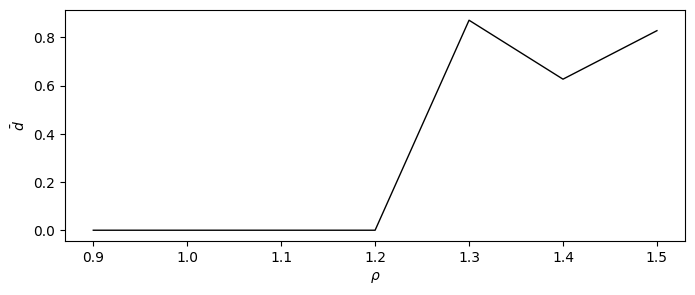

In [ ]:
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(rhos,dbars, color="k",linewidth=1)
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\bar{d}$')

### Conditional Lyapunov Exponent
In addition, we can check the ESP using a conditional Lyapunov exponent.
The Lyapunov exponent is defined for an autonomous system and represents the attractor's feature of the initial sensitivity.
The conditional Lyapunov exponent <sup>[14]</sup> is defined for a non-autonomous system, which includes independent variables of input.

We consider a $N$-dimensional discrete-time system with input.
The state $\boldsymbol{x}_t=[x_{1,t} \cdots x_{N,t}]^\top$ is update via the state equation driven by input $u_t$
\begin{align}
\boldsymbol{x}_{t+1} = \boldsymbol{f}(\boldsymbol{x}_t,u_t), \tag{6}
\end{align}
where $\boldsymbol{f}= [f_1 \cdots f_N]^\top$ is a $N$-dimensional map.

Based on this equation, we can derive a Lyapunov spectrum through the same procedure as the case without input.
As a result, we obtain the conditional Lyapunov spectrum
\begin{align}
\lambda_i &= \frac{1}{T} \ln|\alpha_i|~(i=1,\ldots,N),
\end{align}
where $\alpha_i$ is the eigenvalues of the Jacobian matrix
$$
\boldsymbol{J}_t =
\begin{bmatrix}
\dfrac{\partial f_1}{\partial x_{1,t}} & \cdots & \dfrac{\partial f_1}{\partial x_{N,t}} \\
\vdots & \ddots & \vdots \\ \dfrac{\partial f_N}{\partial x_{1,t}} & \cdots & \dfrac{\partial f_N}{\partial x_{N,t}}
\end{bmatrix}.
$$
Note that the map $\boldsymbol{f}$ is replaced to that with input in Eq. (6).
In the same manner, if the <b>maximum Lyapunov exponent</b> $\max_i \lambda_i>0$, the two trajectories are separated, which indicates the initial sensitivity.

Note that, if $\boldsymbol{x}_{t+1} = \tanh(\boldsymbol{W}\boldsymbol{x}_t+\boldsymbol{W}_{\rm in}u_t)$, the Jacobian can be simplified to
\begin{align}
\boldsymbol{J}_t &= {\rm diag}(\boldsymbol{1}-\tanh^2(\boldsymbol{W}\boldsymbol{x}_t+\boldsymbol{W}_{\rm in}u_t))\cdot\boldsymbol{W} \\
&= {\rm diag}(\boldsymbol{1}-\boldsymbol{x}_{t+1}^2)\cdot\boldsymbol{W},
\end{align}
which is the same as the autonomous case.



### Homework #2: Parameter region where ESN meets the prerequisite
To understand the parameter region where the ESN meets the ESP,
solve the following problem.

1. Select the ESP index or conditional Lyapunov exponent and illustrate a color map of the measure whose axes are the spectral radius $\rho\in[1.0,1.5]$ and the input intensity $\sigma\in[0,1]$.
1. Find the effect of noise-induced order from the map by comparing the above results of $\sigma=0$ and $\sigma>0$.


Text(0, 0.5, '$\\sigma$')

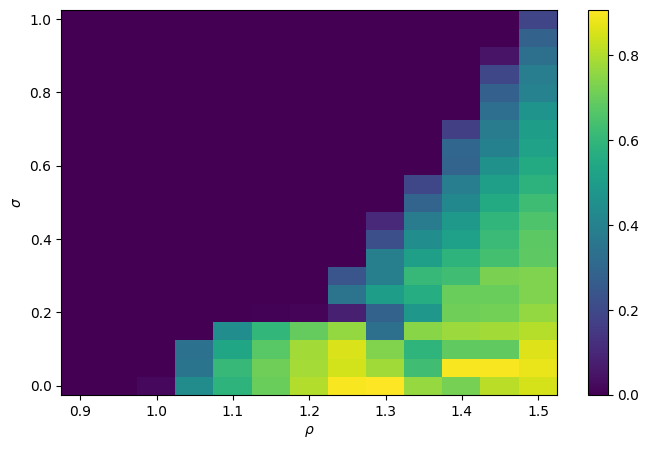

### Summary
The ESP is the prerequisite for RC to make an output reproducibly.
Under this condition, the system state is the echo function (the function of only past input series).
The ESP can be evaluated by two measures
- ESP index
- Conditional Lyapunov exponent



## References

[1] H. Jaeger, <em>The “echo state” approach to analysing and training recurrent neural networks-with an erratum note</em>, Bonn Germany: German National Research Center for Information Technology GMD Technical Report, 148(34), 13 (2001)

[2] H. Jaeger, <em>Tutorial on training recurrent neural networks, covering BPPT, RTRL, EKF and the "echo state network" approach</em>, Bonn: GMD-Forschungszentrum Informationstechnik (2002)

[3] W. Maass, T. Natschlager, and H. Markram, <em>Real-time computing without stable states: A new framework for neural computation based on perturbations</em>, Neural Computation 14, 2351 (2002)

[4] I. B. Yildiz, H. Jaeger, and S. J. Kiebel, <em>Re-visiting the echo state property</em>, Neural Networks 35, 1 (2012)

[5] S. Boyd and C. Leon Chua, <em>Fading memory and the problem of approximating nonlinear operators with Volterra series</em>, IEEE Transactions on circuits and systems 32.11, 1150-1161 (1985)

[6] Z. Lu, B. Hunt, and E. Ott,  <em>Attractor reconstruction by machine learning</em>, Chaos: An Interdisciplinary Journal of Nonlinear Science 28.6, 061104 (2018)

[7] C. Gallicchio,  <em>Chasing the Echo State Property</em>, ESANN 2019 Proceedings (2019)

[8]  田中剛平， 中根了昌，廣瀬明，リザバーコンピューティング：時系列パターン認識のための高速機械学習の理論とハードウェア，森北出版（2021）

[9] K. Kaneko and I. Tsuda, <em>Complex systems: Chaos and beyond</em>, Berlin, Germany: Springer (2012)

[10] V. Chvátal, <em>Notes on the maximal Lyapunov exponent of a time series </em>

[11] V. I. Oseledets, <em>A multiplicative ergodic theorem. Lyapunov characteristic
numbers for dynamical systems</em>, Trans.Moscow Math. Soc. 19, 197–231 (1968)

[12] V. I. Oseledets (2008) Oseledets theorem. Scholarpedia, 3(1):1846
http://www.scholarpedia.org/article/Oseledets_theorem

[13] N. Bertschinger,  T. Natschläger, <em>Real-time computation at the edge of chaos in recurrent neural networks</em>, Neural computation 16.7: 1413-1436 (2004)

[14] D. Verstraeten, et al, <em>An experimental unification of reservoir computing methods</em>, Neural networks 20.3: 391-403 (2007)

[15] D. Verstraeten and B. Schrauwen, Artificial Neural Networks – ICANN 2009, 19th International Conference, Limassol, Cyprus, September 14-17, 2009, Proceedings, Part I, Lect Notes Comput Sc 985 (2009).

[16] J. C. Sprott, <em>Chaos and Time-Series Analysis</em>, Oxford University Press, pp.116-117 (2003) https://sprott.physics.wisc.edu/chaos/lyapexp.htm

[17] I. Shimada, T. Nagashima, <em>A Numerical Approach to Ergodic Problem of Dissipative Dynamical Systems</em>, Progress of Theoretical Physics, Vol. 61, No. 6, pp. 1605-1616 (1979)
